In [7]:
# Analisis dataset

In [8]:
import pandas as pd
import os
from glob import glob

# ================================
# 1. PATH DATASET
# ================================
base_path = "Dataset/"   # karena folder 'Dataset' sejajar dengan notebook

# Ambil semua file dengan pola nama ispu_jakarta_*.xlsx
files = glob(os.path.join(base_path, "ispu_jakarta_*.xlsx"))

print("File ditemukan:\n")
for f in files:
    print(" -", f)
print("\n==================================\n")


# ================================
# 2. MENAMPILKAN FITUR SETIAP FILE
# ================================
print("=== FITUR / KOLOM SETIAP DATASET ===\n")

fitur_per_file = {}

for f in files:
    df = pd.read_excel(f)
    file_name = os.path.basename(f)
    
    fitur_per_file[file_name] = list(df.columns)

    print(f"--- {file_name} ---")
    for col in df.columns:
        print(" •", col)
    print()


# ================================
# 3. PERBANDINGAN FITUR ANTAR DATASET
# ================================
print("\n=== PERBANDINGAN FITUR ANTAR TAHUN ===\n")

all_features = {name.replace(".xlsx", ""): set(cols) 
                for name, cols in fitur_per_file.items()}

file_names = list(all_features.keys())
feature_sets = list(all_features.values())

if len(feature_sets) > 1:
    common = feature_sets[0].intersection(*feature_sets[1:])
else:
    common = feature_sets[0]

print("Fitur umum (ada di semua dataset):\n")
for c in sorted(common):
    print(" •", c)

print("\n==================================\n")
print("Fitur unik tiap dataset:\n")

for name in file_names:
    unique_features = all_features[name] - common
    print(f"--- {name} ---")
    if len(unique_features) == 0:
        print(" (Tidak ada fitur unik)")
    else:
        for u in sorted(unique_features):
            print(" •", u)
    print()

File ditemukan:

 - Dataset/ispu_jakarta_2022.xlsx
 - Dataset/ispu_jakarta_2024_2025.xlsx
 - Dataset/ispu_jakarta_2023.xlsx
 - Dataset/ispu_jakarta_2021.xlsx
 - Dataset/ispu_jakarta_2020.xlsx


=== FITUR / KOLOM SETIAP DATASET ===

--- ispu_jakarta_2022.xlsx ---
 • critical
 • categori
 • lokasi_spku
 • periode_data
 • tanggal
 • pm_10
 • pm_duakomalima
 • so2
 • co
 • o3
 • no2
 • max

--- ispu_jakarta_2024_2025.xlsx ---
 • parameter_pencemar_kritis
 • kategori
 • periode_data
 • bulan
 • tanggal
 • stasiun
 • pm_sepuluh
 • pm_duakomalima
 • sulfur_dioksida
 • karbon_monoksida
 • ozon
 • nitrogen_dioksida
 • max

--- ispu_jakarta_2023.xlsx ---
 • periode_data
 • tanggal
 • stasiun
 • pm_sepuluh
 • pm_duakomalima
 • sulfur_dioksida
 • karbon_monoksida
 • ozon
 • nitrogen_dioksida
 • max
 • parameter_pencemar_kritis
 • kategori

--- ispu_jakarta_2021.xlsx ---
 • periode_data
 • tanggal
 • stasiun
 • pm10
 • pm25
 • so2
 • co
 • o3
 • no2
 • max
 • critical
 • categori

--- ispu_jakarta_

In [9]:
# Merge data 2020-2023

In [10]:
import pandas as pd
import os
import numpy as np

# --- 1. Definisikan Nama Kolom Standar ---
KOLOM_STANDAR = [
    'periode_data', 'tanggal_lengkap', 'tahun', 'bulan', 'hari', 'stasiun',
    'pm10', 'pm25', 'so2', 'co', 'o3', 'no2',
    'max_ispu', 'parameter_kritis', 'kategori'
]

# --- 2. Pemetaan Stasiun untuk Normalisasi ---
STATION_MAP = {
    'DKI1': 'DKI1 Bunderan HI', 'DKI1 Bunderan HI': 'DKI1 Bunderan HI',
    'DKI2': 'DKI2 Kelapa Gading', 'DKI2 Kelapa Gading': 'DKI2 Kelapa Gading',
    'DKI3': 'DKI3 Jagakarsa', 'DKI3 Jagakarsa': 'DKI3 Jagakarsa',
    'DKI4': 'DKI4 Lubang Buaya', 'DKI4 Lubang Buaya': 'DKI4 Lubang Buaya',
    'DKI5': 'DKI5 Kebon Jeruk Jakarta Barat', 'DKI5 Kebon Jeruk Jakarta Barat': 'DKI5 Kebon Jeruk Jakarta Barat',
    'Kebon Jeruk Jakarta Barat': 'DKI5 Kebon Jeruk Jakarta Barat',
    'Bunderan HI': 'DKI1 Bunderan HI', 'Kelapa Gading': 'DKI2 Kelapa Gading',
    'Jagakarsa': 'DKI3 Jagakarsa', 'Lubang Buaya': 'DKI4 Lubang Buaya',
    'DKI5 (Kebon Jeruk) Jakarta Barat': 'DKI5 Kebon Jeruk Jakarta Barat'
}

def normalize_station(station_name):
    """Menyeragamkan nama stasiun berdasarkan STATION_MAP."""
    if isinstance(station_name, str):
        standardized = station_name.strip()
        # Kalau ada di mapping langsung, pakai yang standar
        if standardized in STATION_MAP:
            return STATION_MAP[standardized]
        # Kalau formatnya diawali kode DKI1–DKI5
        parts = standardized.split()
        if parts and parts[0] in ['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']:
            return STATION_MAP.get(parts[0], standardized)
        return standardized
    return station_name


# --- 3. Fungsi Pemrosesan Utama: Memuat, Mengubah Nama, dan Membersihkan ---
def load_and_standardize(file_path, year):
    print(f"\nMemproses data tahun {year} dari file: {file_path}...")
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except FileNotFoundError:
        print(f"❌ ERROR: File tidak ditemukan di {file_path}. Lewati.")
        return None
    except Exception as e:
        print(f"❌ ERROR saat membaca file {file_path}: {e}. Lewati.")
        return None

    # Membersihkan nama kolom dan mengubah ke huruf kecil
    df.columns = df.columns.str.strip().str.lower()

    # --- 3a. Pemetaan Kolom Umum ---
    column_mapping_common = {
        'max': 'max_ispu',
        'critical': 'parameter_kritis',
        'categori': 'kategori',
        'lokasi_spku': 'stasiun',
        'pm_10': 'pm10',
        'pm_duakomalima': 'pm25',
        'pm_sepuluh': 'pm10',
        'sulfur_dioksida': 'so2',
        'karbon_monoksida': 'co',
        'ozon': 'o3',
        'nitrogen_dioksida': 'no2',
        # Satu kolom sumber tanggal
        'tanggal': 'date_source',
    }
    df = df.rename(columns=column_mapping_common, errors='ignore')

    # Pastikan kolom PM2.5 ada, kalau tidak isi NaN
    if 'pm25' not in df.columns:
        df['pm25'] = pd.NA

    # Set default tahun (nanti bisa ditimpa dari tanggal_lengkap)
    df['tahun'] = year

    # --- 3b. Pemrosesan Tanggal ---
    if 'date_source' in df.columns:
        # Ambil hanya bagian tanggal (buang waktu kalau ada)
        df['date_source'] = df['date_source'].astype(str).str.split().str[0]

        df['tanggal_lengkap'] = pd.to_datetime(
            df['date_source'],
            errors='coerce',
            dayfirst=False  # format data kamu cenderung YYYY-MM-DD
        )

        df['bulan'] = df['tanggal_lengkap'].dt.month
        df['hari'] = df['tanggal_lengkap'].dt.day
        df['tahun'] = df['tanggal_lengkap'].dt.year

        df.drop(columns=['date_source'], errors='ignore', inplace=True)
    else:
        df['tanggal_lengkap'] = pd.NaT
        df['bulan'] = pd.NA
        df['hari'] = pd.NA
        df['tahun'] = year

    # --- 3c. Normalisasi Nama Stasiun ---
    if 'stasiun' in df.columns:
        df['stasiun'] = df['stasiun'].apply(normalize_station)
    else:
        df['stasiun'] = pd.NA

    # --- 3d. Reindex ke kolom standar ---
    standardized_df = df.reindex(columns=KOLOM_STANDAR)

    print(f"✅ Data tahun {year} berhasil diseragamkan. Jumlah baris: {len(standardized_df)}")
    return standardized_df


# --- 4. Konfigurasi File Input (2020–2023) ---
base_folder = 'Dataset'

data_files_subset = {
    2020: os.path.join(base_folder, 'ispu_jakarta_2020.xlsx'),
    2021: os.path.join(base_folder, 'ispu_jakarta_2021.xlsx'),
    2022: os.path.join(base_folder, 'ispu_jakarta_2022.xlsx'),
    2023: os.path.join(base_folder, 'ispu_jakarta_2023.xlsx'),
}

all_dataframes = []

for year, file_path in data_files_subset.items():
    df_standard = load_and_standardize(file_path, year)
    if df_standard is not None:
        all_dataframes.append(df_standard)

# --- 5. Menggabungkan dan Menyimpan Hasil ---
if all_dataframes:
    final_df = pd.concat(all_dataframes, ignore_index=True)

    # Konversi kolom polutan & ISPU ke numerik
    kolom_ispu = ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max_ispu']
    for col in kolom_ispu:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

    OUTPUT_FILE = 'data_kualitas_udara_gabungan_2020_2021_2022_2023.csv'
    final_df.to_csv(OUTPUT_FILE, index=False)

    print("\n==============================================")
    print("✅ PROSES GABUNG DATA SELESAI!")
    print(f"Total baris data yang berhasil digabungkan: {len(final_df)}")
    print(f"Hasil disimpan di: {OUTPUT_FILE}")
    print("==============================================")

    print("\nContoh data yang sudah seragam:")
    print(final_df[['tanggal_lengkap', 'stasiun', 'pm10', 'pm25', 'max_ispu', 'kategori']].head(10))
else:
    print("\n❌ Gagal menggabungkan data karena tidak ada file yang berhasil dimuat.")



Memproses data tahun 2020 dari file: Dataset/ispu_jakarta_2020.xlsx...
✅ Data tahun 2020 berhasil diseragamkan. Jumlah baris: 366

Memproses data tahun 2021 dari file: Dataset/ispu_jakarta_2021.xlsx...
✅ Data tahun 2021 berhasil diseragamkan. Jumlah baris: 1825

Memproses data tahun 2022 dari file: Dataset/ispu_jakarta_2022.xlsx...
✅ Data tahun 2022 berhasil diseragamkan. Jumlah baris: 365

Memproses data tahun 2023 dari file: Dataset/ispu_jakarta_2023.xlsx...


/tmp/ipykernel_2681/604567176.py:85: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tanggal_lengkap'] = pd.to_datetime(


✅ Data tahun 2023 berhasil diseragamkan. Jumlah baris: 1825

✅ PROSES GABUNG DATA SELESAI!
Total baris data yang berhasil digabungkan: 4381
Hasil disimpan di: data_kualitas_udara_gabungan_2020_2021_2022_2023.csv

Contoh data yang sudah seragam:
  tanggal_lengkap                         stasiun  pm10  pm25  max_ispu  \
0      2020-05-01  DKI5 Kebon Jeruk Jakarta Barat  55.0   NaN      83.0   
1      2020-05-02  DKI5 Kebon Jeruk Jakarta Barat  36.0   NaN      80.0   
2      2020-05-03  DKI5 Kebon Jeruk Jakarta Barat  65.0   NaN      65.0   
3      2020-05-04  DKI5 Kebon Jeruk Jakarta Barat  53.0   NaN      75.0   
4      2020-05-05  DKI5 Kebon Jeruk Jakarta Barat  53.0   NaN      73.0   
5      2020-05-06  DKI5 Kebon Jeruk Jakarta Barat  52.0   NaN      63.0   
6      2020-05-07  DKI5 Kebon Jeruk Jakarta Barat  67.0   NaN      69.0   
7      2020-05-08  DKI5 Kebon Jeruk Jakarta Barat  91.0   NaN     120.0   
8      2020-05-09               DKI4 Lubang Buaya  77.0   NaN      77.0   
9    

In [11]:
# Menyesuaikan kolom tahun 2024/2025

In [12]:
import pandas as pd
import numpy as np

# ================================
# 1. DEFINISI KOLOM STANDAR
# ================================

KOLOM_STANDAR = [
    'periode_data', 'tanggal_lengkap', 'tahun', 'bulan', 'hari', 'stasiun',
    'pm10', 'pm25', 'so2', 'co', 'o3', 'no2',
    'max_ispu', 'parameter_kritis', 'kategori'
]

FILE_INPUT = "Dataset/ispu_jakarta_2024_2025.xlsx"
OUTPUT_CSV = "ispu_2024_2025_date_fixed.csv"


# ================================
# 2. MEMBANGUN TANGGAL LENGKAP (2024/2025)
# ================================

def fix_2024_2025_date_columns(file_path, target_year):

    print(f"\n--- Memproses data tahun {target_year} ---")

    try:
        df = pd.read_excel(file_path, engine="openpyxl")
    except Exception as e:
        print("❌ ERROR membaca file:", e)
        return None

    # Normalisasi kolom
    df.columns = df.columns.str.strip().str.lower()

    # Ambil tahun dari periode_data (format: 2024-01, 2025-06, dst.)
    df['tahun_data_temp'] = df['periode_data'].astype(str).str[:4].astype(int)

    # Filter data sesuai tahun
    df_filtered = df[df['tahun_data_temp'] == target_year].copy()

    if df_filtered.empty:
        print("⚠ Tidak ada data untuk tahun", target_year)
        return None

    # Bangun ulang tanggal lengkap
    df_filtered.rename(columns={'tanggal': 'hari_num_temp'}, inplace=True)

    df_filtered['bulan'] = df_filtered['bulan'].fillna(1).astype(int)
    df_filtered['hari_num_temp'] = df_filtered['hari_num_temp'].fillna(1).astype(int)

    df_filtered['tanggal_string'] = (
        df_filtered['tahun_data_temp'].astype(str) + "-" +
        df_filtered['bulan'].astype(str).str.zfill(2) + "-" +
        df_filtered['hari_num_temp'].astype(str).str.zfill(2)
    )

    df_filtered['tanggal_lengkap'] = pd.to_datetime(
        df_filtered['tanggal_string'], errors='coerce'
    )

    # Debug contoh
    print("\nContoh hasil rekonstruksi tanggal:")
    print(df_filtered[['tanggal_lengkap', 'stasiun', 'kategori']].head(5).to_string(index=False))

    df_filtered.drop(columns=['tanggal_string'], inplace=True, errors='ignore')
    return df_filtered


# ================================
# 3. STANDARDISASI KOLOM 2024/2025
# ================================

def standardize_and_save_final_2024_data(df_raw, output_csv):

    rename_map = {
        'pm_duakomalima': 'pm25',
        'pm_sepuluh': 'pm10',
        'sulfur_dioksida': 'so2',
        'karbon_monoksida': 'co',
        'ozon': 'o3',
        'nitrogen_dioksida': 'no2',
        'max': 'max_ispu',
        'parameter_pencemar_kritis': 'parameter_kritis'
    }

    df = df_raw.rename(columns=rename_map, errors='ignore')

    # Ambil komponen waktu dari tanggal_lengkap
    df['tahun'] = df['tanggal_lengkap'].dt.year
    df['bulan'] = df['tanggal_lengkap'].dt.month
    df['hari'] = df['tanggal_lengkap'].dt.day

    # Reindex ke kolom standar
    df_final = df.reindex(columns=KOLOM_STANDAR)

    # Simpan
    df_final.to_csv(output_csv, index=False)

    return df_final


# ================================
# 4. EKSEKUSI UTAMA
# ================================

if __name__ == "__main__":

    df_2024 = fix_2024_2025_date_columns(FILE_INPUT, 2024)
    df_2025 = fix_2024_2025_date_columns(FILE_INPUT, 2025)

    # Gabungkan kedua tahun
    valid_frames = [df for df in [df_2024, df_2025] if df is not None]

    if not valid_frames:
        print("❌ Tidak ada data yang bisa digabungkan.")
    else:
        df_merged = pd.concat(valid_frames, ignore_index=True)

        df_standardized = standardize_and_save_final_2024_data(df_merged, OUTPUT_CSV)

        print("\n===============================================")
        print(f"Jumlah baris data 2024–2025: {len(df_standardized)}")
        print(f"File final disimpan sebagai: {OUTPUT_CSV}")
        print("===============================================")



--- Memproses data tahun 2024 ---

Contoh hasil rekonstruksi tanggal:
tanggal_lengkap         stasiun kategori
     2024-01-21 DKI3  Jagakarsa   SEDANG
     2024-01-22 DKI3  Jagakarsa   SEDANG
     2024-01-23 DKI3  Jagakarsa   SEDANG
     2024-01-24 DKI3  Jagakarsa   SEDANG
     2024-01-25 DKI3  Jagakarsa   SEDANG

--- Memproses data tahun 2025 ---

Contoh hasil rekonstruksi tanggal:
tanggal_lengkap          stasiun kategori
     2025-04-24 DKI5 Kebon Jeruk     BAIK
     2025-04-25 DKI5 Kebon Jeruk   SEDANG
     2025-04-26 DKI5 Kebon Jeruk   SEDANG
     2025-04-27 DKI5 Kebon Jeruk   SEDANG
     2025-04-28 DKI5 Kebon Jeruk   SEDANG

Jumlah baris data 2024–2025: 3045
File final disimpan sebagai: ispu_2024_2025_date_fixed.csv


In [13]:
# Menggabungkan semua data

In [14]:
import pandas as pd
import os
import numpy as np

# --- 1. KONFIGURASI FILE INPUT & OUTPUT ---
FILE_2020_2023 = 'data_kualitas_udara_gabungan_2020_2021_2022_2023.csv'
FILE_2024_2025 = 'ispu_2024_2025_date_fixed.csv'
FINAL_OUTPUT_FILE = 'data_kualitas_udara_gabungan_final.csv'

# --- 2. FINAL CLEANUP CONFIG ---
KOLOM_POLUTAN = ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max_ispu']

def final_merge_and_clean():
    print("--- ⚙️ TAHAP AKHIR: PENGGABUNGAN DATA & FINAL CLEANUP ---")
    
    # Muat file 2020-2023
    try:
        df_a = pd.read_csv(FILE_2020_2023)
        print(f"✅ Dimuat: {FILE_2020_2023} ({len(df_a)} baris)")
    except FileNotFoundError:
        print(f"❌ ERROR: File {FILE_2020_2023} tidak ditemukan. Proses dibatalkan.")
        return

    # Muat file 2024-2025
    try:
        df_b = pd.read_csv(FILE_2024_2025)
        print(f"✅ Dimuat: {FILE_2024_2025} ({len(df_b)} baris)")
    except FileNotFoundError:
        print(f"❌ ERROR: File {FILE_2024_2025} tidak ditemukan. Proses dibatalkan.")
        return

    # --- 3. PENGGABUNGAN (CONCATENATION) ---
    final_df = pd.concat([df_a, df_b], ignore_index=True)
    print(f"\n✅ Total baris setelah penggabungan: {len(final_df)}")
    
    # --- 4. FINAL CLEANUP DAN KONVERSI NUMERIK ---
    
    # Pastikan kolom tanggal adalah datetime (Wajib, karena CSV bisa menyimpannya sebagai string)
    final_df['tanggal_lengkap'] = pd.to_datetime(final_df['tanggal_lengkap'], errors='coerce')
    
    # Konversi kolom polutan ke numerik
    for col in KOLOM_POLUTAN:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce') 

    # --- 5. SIMPAN HASIL ---
    final_df.to_csv(FINAL_OUTPUT_FILE, index=False)
    
    print("\n==============================================")
    print("✅ PROSES FINAL MERGE SELESAI!")
    print(f"Total baris data yang berhasil digabungkan: {len(final_df)}")
    print(f"Hasil disimpan di: {FINAL_OUTPUT_FILE}")
    print("==============================================")

    # --- PERBAIKAN TAMPILAN: Menggunakan to_string() ---
    print("\nContoh 5 baris terakhir (Termasuk data 2024/2025):")
    print(final_df[['tanggal_lengkap', 'stasiun', 'pm10', 'pm25', 'max_ispu', 'kategori']].tail(5).to_string(index=False))

# --- EKSEKUSI UTAMA ---
if __name__ == '__main__':
    final_merge_and_clean()

--- ⚙️ TAHAP AKHIR: PENGGABUNGAN DATA & FINAL CLEANUP ---
✅ Dimuat: data_kualitas_udara_gabungan_2020_2021_2022_2023.csv (4381 baris)
✅ Dimuat: ispu_2024_2025_date_fixed.csv (3045 baris)

✅ Total baris setelah penggabungan: 7426

✅ PROSES FINAL MERGE SELESAI!
Total baris data yang berhasil digabungkan: 7426
Hasil disimpan di: data_kualitas_udara_gabungan_final.csv

Contoh 5 baris terakhir (Termasuk data 2024/2025):
tanggal_lengkap           stasiun  pm10  pm25  max_ispu       kategori
     2025-08-31    DKI3 Jagakarsa  28.0  60.0      60.0         SEDANG
     2025-08-01 DKI4 Lubang Buaya  63.0  89.0      89.0         SEDANG
     2025-08-02 DKI4 Lubang Buaya  73.0 105.0     105.0    TIDAK SEHAT
     2025-08-03 DKI4 Lubang Buaya   NaN   NaN       NaN TIDAK ADA DATA
     2025-08-04 DKI4 Lubang Buaya  63.0  84.0      84.0         SEDANG


# SETUP & LOAD DATA

In [15]:
# 1. Import library utama & load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (opsional) agar grafik tampil lebih rapi di notebook
plt.style.use("default")

# Path ke file CSV (sesuai permintaan)
DATA_PATH = "data_kualitas_udara_gabungan_final.csv"

# Load data
df = pd.read_csv(DATA_PATH)

# Tampilkan 5 baris pertama
df.head()


Matplotlib is building the font cache; this may take a moment.


,periode_data,tanggal_lengkap,tahun,bulan,hari,stasiun,pm10,pm25,so2,co,o3,no2,max_ispu,parameter_kritis,kategori
0,202005,2020-05-01,2020.0,5.0,1.0,DKI5 Kebon Jeruk Jakarta Barat,55.0,NaN,26.0,21.0,83.0,10.0,83.0,O3,SEDANG
1,202005,2020-05-02,2020.0,5.0,2.0,DKI5 Kebon Jeruk Jakarta Barat,36.0,NaN,22.0,12.0,80.0,9.0,80.0,O3,SEDANG
2,202005,2020-05-03,2020.0,5.0,3.0,DKI5 Kebon Jeruk Jakarta Barat,65.0,NaN,34.0,35.0,49.0,11.0,65.0,PM10,SEDANG
3,202005,2020-05-04,2020.0,5.0,4.0,DKI5 Kebon Jeruk Jakarta Barat,53.0,NaN,21.0,14.0,75.0,8.0,75.0,O3,SEDANG
4,202005,2020-05-05,2020.0,5.0,5.0,DKI5 Kebon Jeruk Jakarta Barat,53.0,NaN,22.0,18.0,73.0,9.0,73.0,O3,SEDANG


# STRUKTUR DATA & TIPE KOLOM

In [3]:
# 2. Lihat ukuran data, tipe kolom, dan info dasar

print("Jumlah baris, kolom:", df.shape)
print("\nInfo dataframe:")
print(df.info())

print("\nContoh 10 baris pertama:")
display(df.head(10))


Jumlah baris, kolom: (7426, 15)

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7426 entries, 0 to 7425
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   periode_data      7426 non-null   int64  
 1   tanggal_lengkap   7425 non-null   object 
 2   tahun             7425 non-null   float64
 3   bulan             7425 non-null   float64
 4   hari              7425 non-null   float64
 5   stasiun           7426 non-null   object 
 6   pm10              6950 non-null   float64
 7   pm25              6612 non-null   float64
 8   so2               7207 non-null   float64
 9   co                7301 non-null   float64
 10  o3                7286 non-null   float64
 11  no2               7259 non-null   float64
 12  max_ispu          7415 non-null   float64
 13  parameter_kritis  5521 non-null   object 
 14  kategori          7425 non-null   object 
dtypes: float64(10), int64(1), object(4)
memo

,periode_data,tanggal_lengkap,tahun,bulan,hari,stasiun,pm10,pm25,so2,co,o3,no2,max_ispu,parameter_kritis,kategori
0,202005,2020-05-01,2020.0,5.0,1.0,DKI5 Kebon Jeruk Jakarta Barat,55.0,NaN,26.0,21.0,83.0,10.0,83.0,O3,SEDANG
1,202005,2020-05-02,2020.0,5.0,2.0,DKI5 Kebon Jeruk Jakarta Barat,36.0,NaN,22.0,12.0,80.0,9.0,80.0,O3,SEDANG
2,202005,2020-05-03,2020.0,5.0,3.0,DKI5 Kebon Jeruk Jakarta Barat,65.0,NaN,34.0,35.0,49.0,11.0,65.0,PM10,SEDANG
3,202005,2020-05-04,2020.0,5.0,4.0,DKI5 Kebon Jeruk Jakarta Barat,53.0,NaN,21.0,14.0,75.0,8.0,75.0,O3,SEDANG
4,202005,2020-05-05,2020.0,5.0,5.0,DKI5 Kebon Jeruk Jakarta Barat,53.0,NaN,22.0,18.0,73.0,9.0,73.0,O3,SEDANG
5,202005,2020-05-06,2020.0,5.0,6.0,DKI5 Kebon Jeruk Jakarta Barat,52.0,NaN,22.0,14.0,63.0,7.0,63.0,O3,SEDANG
6,202005,2020-05-07,2020.0,5.0,7.0,DKI5 Kebon Jeruk Jakarta Barat,67.0,NaN,24.0,18.0,69.0,9.0,69.0,O3,SEDANG
7,202005,2020-05-08,2020.0,5.0,8.0,DKI5 Kebon Jeruk Jakarta Barat,91.0,NaN,22.0,18.0,120.0,10.0,120.0,O3,TIDAK SEHAT
8,202005,2020-05-09,2020.0,5.0,9.0,DKI4 Lubang Buaya,77.0,NaN,22.0,22.0,75.0,12.0,77.0,PM10,SEDANG
9,202005,2020-05-10,2020.0,5.0,10.0,DKI5 Kebon Jeruk Jakarta Barat,72.0,NaN,23.0,27.0,81.0,15.0,81.0,O3,SEDANG


In [ ]:
# CEK MISSING VALUE

In [4]:
# 3. Cek missing value per kolom

missing_counts = df.isna().sum()
missing_percent = df.isna().mean() * 100

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent.round(2)
}).sort_values("missing_percent", ascending=False)

print("Missing value per kolom:")
display(missing_df)


Missing value per kolom:


,missing_count,missing_percent
parameter_kritis,1905,25.65
pm25,814,10.96
pm10,476,6.41
so2,219,2.95
no2,167,2.25
o3,140,1.89
co,125,1.68
max_ispu,11,0.15
tahun,1,0.01
tanggal_lengkap,1,0.01


In [ ]:
# KONVERSI TIPE DATA PENTING (TANGGAL & NUMERIK)

In [5]:
# 4. Memastikan kolom tanggal & numerik sudah bertipe benar

# Konversi tanggal_lengkap ke datetime 
if "tanggal_lengkap" in df.columns:
    df["tanggal_lengkap"] = pd.to_datetime(df["tanggal_lengkap"], errors="coerce")

# Pastikan kolom polutan & ISPU numerik (jika ada)
numerical_cols = ["pm10", "pm25", "so2", "co", "o3", "no2", "max_ispu"]

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Tipe data setelah konversi:")
print(df.dtypes)


Tipe data setelah konversi:
periode_data                 int64
tanggal_lengkap     datetime64[ns]
tahun                      float64
bulan                      float64
hari                       float64
stasiun                     object
pm10                       float64
pm25                       float64
so2                        float64
co                         float64
o3                         float64
no2                        float64
max_ispu                   float64
parameter_kritis            object
kategori                    object
dtype: object


In [ ]:
# STATISTIKA DESKRIPTIF POLUTAN & ISPU

In [6]:
# 5. Statistika deskriptif untuk variabel numerik utama

num_cols_present = [c for c in numerical_cols if c in df.columns]
print("Kolom numerik dianalisis:", num_cols_present)

desc = df[num_cols_present].describe().T
desc["median"] = df[num_cols_present].median()
desc["var"] = df[num_cols_present].var()
desc["missing"] = df[num_cols_present].isna().sum()
display(desc)


Kolom numerik dianalisis: ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max_ispu']


,count,mean,std,min,25%,50%,75%,max,median,var,missing
pm10,6950.0,52.005180,16.067000,3.0,41.0,54.0,63.0,187.0,54.0,258.148484,476
pm25,6612.0,75.855868,24.138490,10.0,60.0,77.0,91.0,287.0,77.0,582.666713,814
so2,7207.0,36.823921,14.640012,2.0,25.0,36.0,51.0,112.0,36.0,214.329941,219
co,7301.0,14.291878,7.203167,1.0,9.0,13.0,18.0,75.0,13.0,51.885618,125
o3,7286.0,30.931787,19.594563,2.0,18.0,26.0,37.0,213.0,26.0,383.946891,140
no2,7259.0,22.334757,13.504041,0.0,13.0,19.0,29.0,202.0,19.0,182.359127,167
max_ispu,7415.0,76.026837,23.988228,0.0,60.0,76.0,91.0,287.0,76.0,575.435077,11


In [ ]:
# DISTRIBUSI SETIAP POLUTAN (HISTOGRAM)

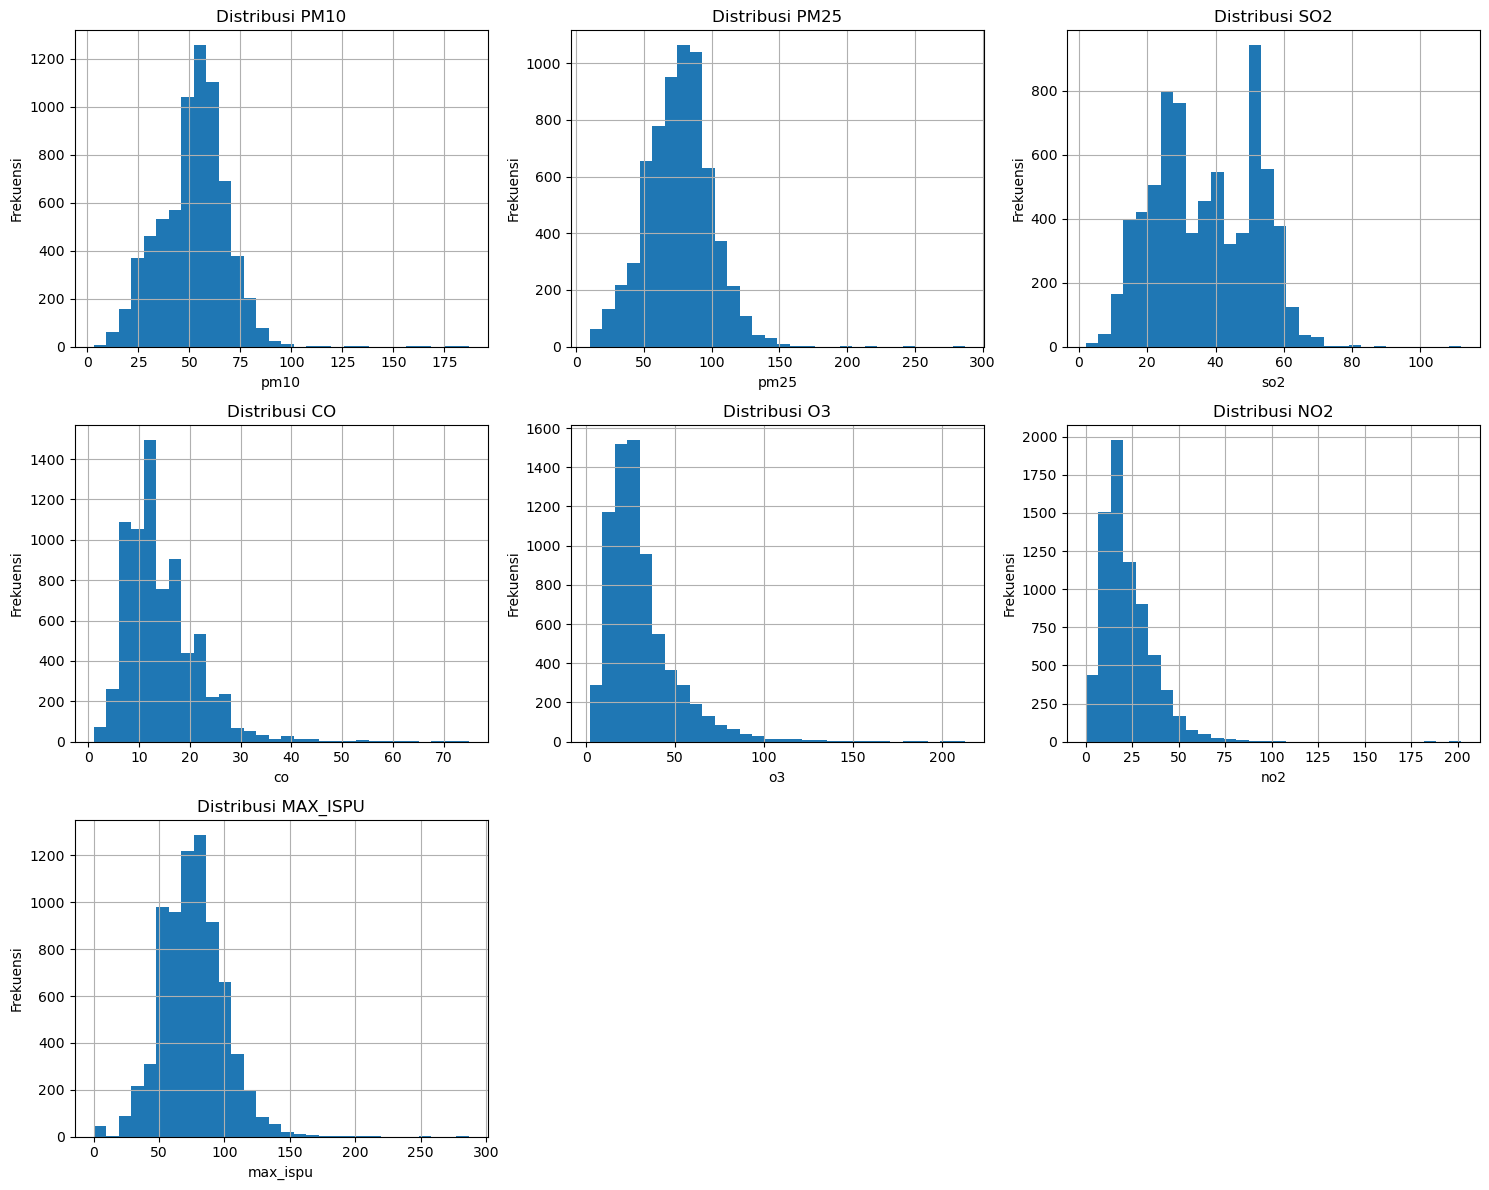

In [7]:
# 6. Plot distribusi (histogram) untuk tiap polutan

num_cols_present = [c for c in numerical_cols if c in df.columns]

n_cols = 3
n_rows = int(np.ceil(len(num_cols_present) / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(num_cols_present, 1):
    plt.subplot(n_rows, n_cols, i)
    df[col].hist(bins=30)
    plt.title(f"Distribusi {col.upper()}")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()


In [ ]:
# DISTRIBUSI KATEGORI ISPU (KOLOM kategori)

Distribusi kategori ISPU:


,count,percent
kategori,,
SEDANG,5529,74.45
TIDAK SEHAT,1018,13.71
BAIK,816,10.99
TIDAK ADA DATA,55,0.74
SANGAT TIDAK SEHAT,7,0.09
NaN,1,0.01


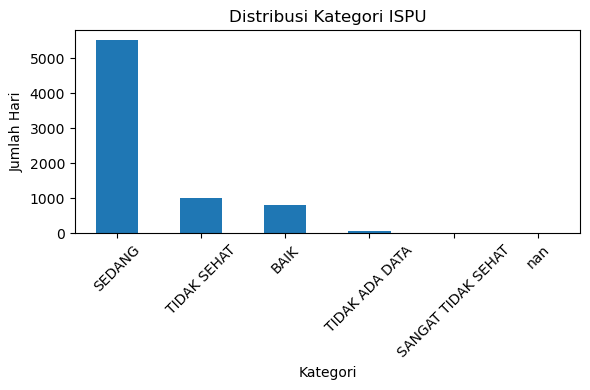

In [8]:
# 7. Distribusi kategori kualitas udara (ISPU)

if "kategori" in df.columns:
    kategori_counts = df["kategori"].value_counts(dropna=False)
    kategori_percent = df["kategori"].value_counts(normalize=True, dropna=False) * 100

    kategori_df = pd.DataFrame({
        "count": kategori_counts,
        "percent": kategori_percent.round(2)
    })

    print("Distribusi kategori ISPU:")
    display(kategori_df)

    # Plot bar chart
    plt.figure(figsize=(6,4))
    kategori_counts.plot(kind="bar")
    plt.title("Distribusi Kategori ISPU")
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah Hari")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'kategori' tidak ditemukan di dataframe.")


In [ ]:
# TREND WAKTU: RATA-RATA POLUTAN PER BULAN

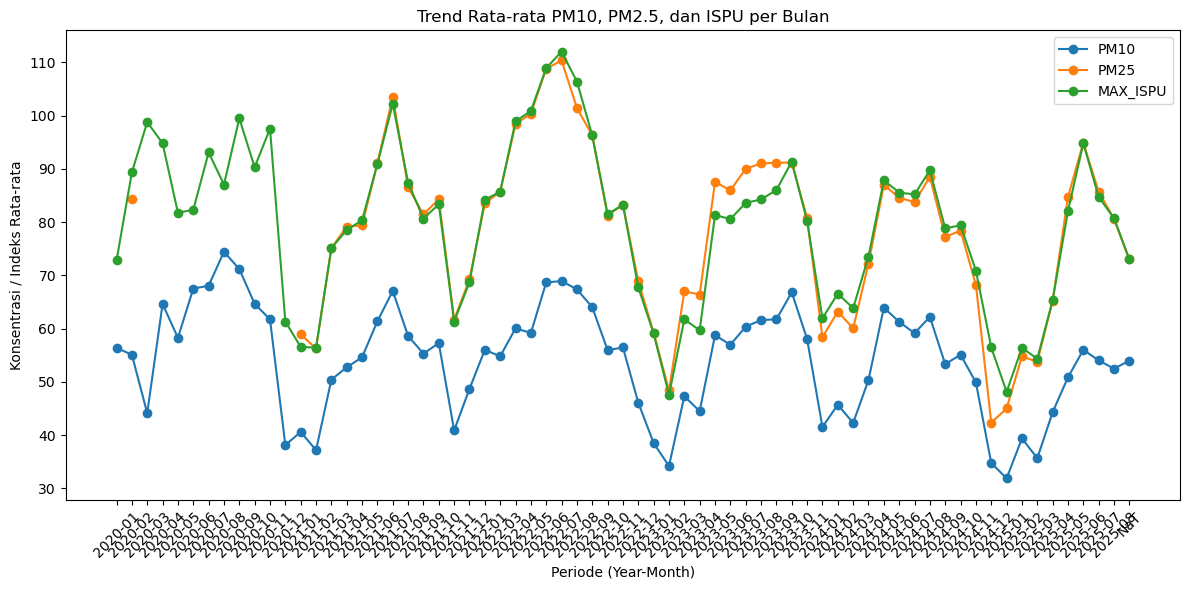

In [9]:
# 8. Trend waktu: rata-rata polutan per bulan

if "tanggal_lengkap" in df.columns:
    df_sorted = df.sort_values("tanggal_lengkap").copy()
    df_sorted["year_month"] = df_sorted["tanggal_lengkap"].dt.to_period("M").astype(str)

    agg_month = df_sorted.groupby("year_month")[num_cols_present].mean()

    plt.figure(figsize=(12,6))
    for col in ["pm10", "pm25", "max_ispu"]:
        if col in agg_month.columns:
            plt.plot(agg_month.index, agg_month[col], marker="o", label=col.upper())

    plt.title("Trend Rata-rata PM10, PM2.5, dan ISPU per Bulan")
    plt.xlabel("Periode (Year-Month)")
    plt.ylabel("Konsentrasi / Indeks Rata-rata")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'tanggal_lengkap' tidak ditemukan, tidak bisa membuat trend waktu.")


In [ ]:
# ANALISIS PER STASIUN: RATA-RATA POLUTAN & ISPU

Rata-rata polutan & ISPU per stasiun:


,pm10,pm25,so2,co,o3,no2,max_ispu
stasiun,,,,,,,
0,54.00,100.00,49.50,29.50,44.00,32.00,86.00
DKI1 Bundaran Hotel Indonesia (HI),44.80,63.02,26.04,17.35,22.12,31.85,64.54
DKI1 Bunderan HI,49.37,69.96,20.73,17.86,24.40,33.92,70.20
DKI1 Bundaran Hotel Indonesia HI,53.07,87.50,33.00,16.83,16.27,39.97,87.50
DKI1 Bundaran Hotel Indonesia (HI),48.97,73.01,24.86,19.43,17.89,34.79,73.83
DKI1 Bunderan HI,50.81,71.37,35.57,11.88,23.99,24.95,71.50
DKI2 Kelapa Gading,41.80,56.47,54.84,9.83,16.88,35.00,61.71
DKI2 Kelapa Gading,55.50,74.88,43.31,12.59,34.77,21.12,75.79
DKI3 Jagakarsa,47.63,62.43,42.05,17.00,12.52,37.83,69.73


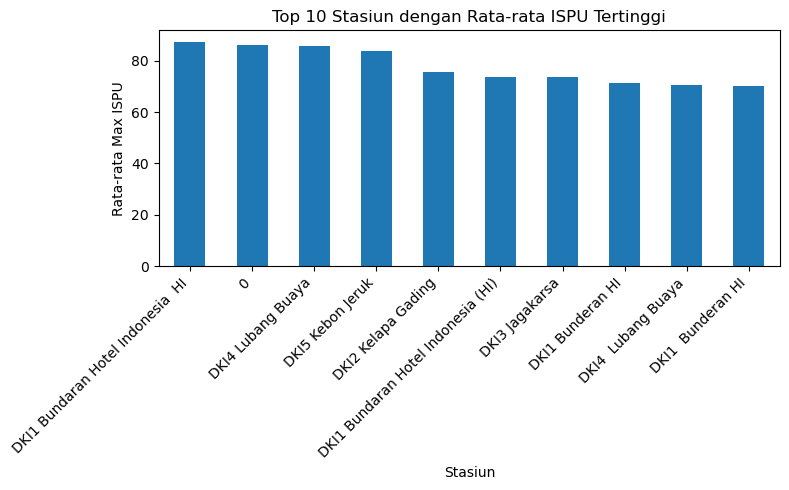

In [10]:
# 9. Rata-rata kualitas udara per stasiun

if "stasiun" in df.columns:
    station_agg = df.groupby("stasiun")[num_cols_present].mean().round(2)

    print("Rata-rata polutan & ISPU per stasiun:")
    display(station_agg)

    # Visualisasi rata-rata max_ispu per stasiun (top 10)
    if "max_ispu" in station_agg.columns:
        top10_ispu = station_agg["max_ispu"].sort_values(ascending=False).head(10)

        plt.figure(figsize=(8,5))
        top10_ispu.plot(kind="bar")
        plt.title("Top 10 Stasiun dengan Rata-rata ISPU Tertinggi")
        plt.xlabel("Stasiun")
        plt.ylabel("Rata-rata Max ISPU")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
else:
    print("Kolom 'stasiun' tidak ditemukan di dataframe.")


In [ ]:
# KORELASI ANTAR POLUTAN (HEATMAP SEDERHANA)

Matriks korelasi:


,pm10,pm25,so2,co,o3,no2,max_ispu
pm10,1.000000,0.765207,0.213688,0.295537,0.251389,0.191636,0.756093
pm25,0.765207,1.000000,0.123190,0.321969,0.319566,0.204142,0.959701
so2,0.213688,0.123190,1.000000,-0.168101,-0.039175,0.158077,0.199369
co,0.295537,0.321969,-0.168101,1.000000,0.231294,0.192770,0.299720
o3,0.251389,0.319566,-0.039175,0.231294,1.000000,-0.110133,0.337668
no2,0.191636,0.204142,0.158077,0.192770,-0.110133,1.000000,0.252306
max_ispu,0.756093,0.959701,0.199369,0.299720,0.337668,0.252306,1.000000


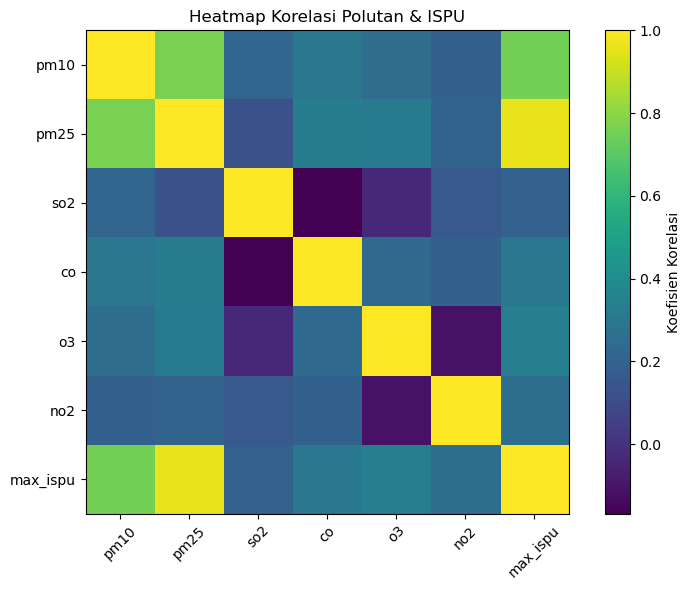

In [11]:
# 10. Korelasi antar variabel polutan & ISPU

corr = df[num_cols_present].corr()

print("Matriks korelasi:")
display(corr)

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation="nearest")
plt.colorbar(label="Koefisien Korelasi")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Heatmap Korelasi Polutan & ISPU")
plt.tight_layout()
plt.show()


In [ ]:
# Cek duplikasi seluruh baris

In [12]:
# 11A. Cek duplikasi seluruh baris

total_duplicates = df.duplicated().sum()
print("Jumlah baris duplikat (seluruh kolom sama persis):", total_duplicates)

# Jika ingin lihat baris duplikatnya:
df[df.duplicated()].head()


Jumlah baris duplikat (seluruh kolom sama persis): 0


,periode_data,tanggal_lengkap,tahun,bulan,hari,stasiun,pm10,pm25,so2,co,o3,no2,max_ispu,parameter_kritis,kategori


In [ ]:
Cek duplikasi berdasarkan kolom tanggal saja

In [13]:
# 11B. Cek duplikasi berdasarkan tanggal_lengkap

if "tanggal_lengkap" in df.columns:
    dup_date = df["tanggal_lengkap"].duplicated().sum()
    print("Jumlah tanggal yang muncul lebih dari sekali:", dup_date)
    
    # Tampilkan tanggal yang terduplikasi
    duplicate_dates = df[df["tanggal_lengkap"].duplicated()]["tanggal_lengkap"]
    display(duplicate_dates.head())
else:
    print("Kolom 'tanggal_lengkap' tidak ditemukan.")


Jumlah tanggal yang muncul lebih dari sekali: 5415


114   2020-03-31
404   2021-02-01
405   2021-02-02
406   2021-02-03
407   2021-02-04
Name: tanggal_lengkap, dtype: datetime64[ns]

In [ ]:
# Cek duplikasi berdasarkan Tanggal + Stasiun (paling relevan)

In [14]:
# 11C. Cek duplikasi berdasarkan kombinasi tanggal + stasiun

if "tanggal_lengkap" in df.columns and "stasiun" in df.columns:
    dup_tgl_stasiun = df.duplicated(subset=["tanggal_lengkap", "stasiun"]).sum()
    print("Jumlah duplikasi berdasarkan (tanggal_lengkap + stasiun):", dup_tgl_stasiun)

    # Tampilkan baris duplikat
    duplicate_rows = df[df.duplicated(subset=["tanggal_lengkap", "stasiun"], keep=False)]
    print("\nContoh baris duplikat:")
    display(duplicate_rows.head())
else:
    print("Kolom 'tanggal_lengkap' atau 'stasiun' tidak ditemukan.")


Jumlah duplikasi berdasarkan (tanggal_lengkap + stasiun): 40

Contoh baris duplikat:


,periode_data,tanggal_lengkap,tahun,bulan,hari,stasiun,pm10,pm25,so2,co,o3,no2,max_ispu,parameter_kritis,kategori
113,202003,2020-03-31,2020.0,3.0,31.0,DKI4 Lubang Buaya,53.0,NaN,9.0,10.0,76.0,5.0,76.0,O3,SEDANG
114,202003,2020-03-31,2020.0,3.0,31.0,DKI4 Lubang Buaya,47.0,NaN,11.0,14.0,96.0,6.0,96.0,O3,SEDANG
217,202002,2020-02-03,2020.0,2.0,3.0,DKI4 Lubang Buaya,59.0,NaN,30.0,50.0,46.0,15.0,59.0,PM10,SEDANG
218,202002,2020-02-04,2020.0,2.0,4.0,DKI3 Jagakarsa,43.0,NaN,30.0,53.0,51.0,14.0,53.0,CO,SEDANG
222,202002,2020-02-08,2020.0,2.0,8.0,DKI4 Lubang Buaya,74.0,NaN,30.0,24.0,67.0,12.0,74.0,PM10,SEDANG


In [ ]:
# Berarti ada kesalahan input tanggal